# Salford Dataset - First Look

In [1]:
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
from IPython.display import display

%load_ext autoreload
%autoreload 1
%aimport datasets.salford, datasets.salford_raw, datasets.icd10, datasets.ccs
from datasets.salford import SalfordData, SalfordFeatures
from datasets.salford_raw import SalfordTimeseries
from datasets.icd10 import ICD10Table
from datasets.ccs import CCSTable

class Notebook:
    DATA_DIR = 'data/Salford'
    FROM_EXCEL = False
    RE_DERIVE = False

We load the raw dataset. We can extract the data from the original .xlsx files, but this takes ~20 minutes. We prefer to load the pre-extracted dataframe.

In [8]:
def load_salford_from_excel():
    infiles = [f'{Notebook.DATA_DIR}/part1.xlsx', f'{Notebook.DATA_DIR}/part2.xlsx']
    xlsx = [pd.read_excel(_) for _ in infiles]
    df = pd.concat(xlsx)
    df.to_hdf(f'{Notebook.DATA_DIR}/raw.h5', 'table')
    return df

if Notebook.FROM_EXCEL:
    sal_raw = load_salford_from_excel()
else:
    sal_raw = pd.read_hdf(f'{Notebook.DATA_DIR}/raw.h5', 'table')

We load the raw dataframe into a SalfordData instance. Calling `from_raw` also performs the basic pre-processing steps for us. Calling `augment_derive_all` augments the dataset with some composite features, such as critical care and mortality outcomes or identifying readmissions.

In [13]:
if Notebook.RE_DERIVE:
    sal = SalfordData.from_raw(sal_raw).augment_derive_all()
    sal.to_hdf(f'{Notebook.DATA_DIR}/sal_processed.h5', 'table')
else:
    sal = SalfordData(pd.read_hdf(f'{Notebook.DATA_DIR}/sal_processed.h5', 'table'))

## Data Availability
We inspect the data availability of the timeseries features.

In [4]:
timeseries_availability = (pd.DataFrame([(
        feature.split('_')[0],
        feature.split('_')[1],
        sal[cols[0]].notna().sum(),
        sal[cols[1]].notna().sum(),
        sal[cols[2]].notna().sum(),
        sal[cols[3]].notna().sum()
    ) for feature, cols in SalfordTimeseries.items()],
    columns=['Group', 'Feature', 'Admission', '24H Post-Adm', '24H Pre-Disch', 'Discharge']
).set_index(['Group', 'Feature'])/sal.shape[0]*100).round(2)
timeseries_availability.loc[['NEWS', 'Blood', 'VBG']]

Admission  24H Post-Adm  24H Pre-Disch  Discharge
Group Feature                                                           
NEWS  Score                71.53         46.97          49.64      72.06
      RespiratoryRate      67.41         44.59          47.04      68.15
      BreathingDevice      67.41         44.59          47.04      68.15
      O2Sat                67.41         44.59          47.04      68.15
      Temperature          67.41         44.59          47.04      68.15
      BP                   67.41         44.59          47.04      68.15
      HeartRate            67.41         44.59          47.04      68.15
      AVCPU                67.41         44.59          47.04      68.15
Blood Haemoglobin          79.65         13.17           3.64      39.11
      Urea                 78.57         14.41           4.48      41.03
      Sodium               78.57         15.07           4.77      42.25
      Potassium            69.45         14.62           4.76      42.31
      Creatinine           78.51         14.74           6.08      65.22
      DDimer                5.58          0.00           0.00       0.42
      CRP                  66.12          7.71           2.08      31.15
      Albumin              67.23         10.64           3.10      36.62
      WhiteCount           79.65         13.17           3.64      39.10
VBG   Temperature           6.66          0.05           0.03       1.31
      pCO2                  6.65          0.05           0.03       1.29
      pCO2                  6.65          0.05           0.03       1.29
      PH                    6.65          0.05           0.03       1.29
      PH                    6.65          0.05           0.03       1.29
      O2                    6.64          0.05           0.03       1.29
      O2                    6.64          0.05           0.03       1.29

In [7]:
# print(timeseries_availability.to_latex(escape=False, index=True, multirow=True, formatters=[
#     lambda x: f'${x:.2f}\%$' for _ in range(4)
# ]))

We do the same across all features.

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print((sal.notna().sum(axis=0)/sal.shape[0]*100))#.apply(lambda x: f'${x:.2f}\%$'))

PatientNumber                       100.000000
Female                              100.000000
Age                                 100.000000
Ethnicity                            99.629844
AE_PresentingComplaint               66.599743
AE_MainDiagnosis                     60.826201
AE_Arrival                           68.299822
AE_Departure                         68.299822
AE_Location                          68.082610
AE_PatientGroup                      68.299822
AE_TriageNote                        67.937885
AdmissionDate                       100.000000
DischargeDate                       100.000000
ElectiveAdmission                   100.000000
AdmitMethod                         100.000000
AdmissionSpecialty                  100.000000
DischargeConsultant                 100.000000
DischargeSpecialty                  100.000000
TotalLOS                            100.000000
LOSBand                             100.000000
AdmitWard                            99.825384
AdmitWardLOS 

## ICD-10 Groupings

We fuzzily match the recorded ICD-10 coded diagnoses with the standard lookup table. Some limited losses occur.

In [12]:
icd = ICD10Table.fuzzy_match(sal.Diagnoses)
print(f'Values that we lost due to ICD-10 matching: {sal.Diagnoses.notna().values.sum() - icd.notna().values.sum()} out of {sal.Diagnoses.notna().values.sum()}')

Values that we lost due to ICD-10 matching: 1018 out of 3134818


We may then conver this standardised format into [CCS](https://ibis.health.utah.gov/ibisph-view/pdf/resource/CCS.pdf) diagnosis groups.

In [11]:
ccs = CCSTable.fuzzy_match(icd)
print(f'Values that we lost due to CCS matching: {ccs.notna().values.sum() - icd.notna().values.sum()}')

Values that we lost due to CCS matching: 0


These are then easy to convert to more compact formats, like the HSMR aggregate groups.

In [14]:
# Group from scratch using the SalfordData method
# Use clean_icd10=True to perform the ICD-10 matching before converting to CCS and subsequently HSMR
sal.derive_ccs(return_df=True, clean_icd10=True, grouping='HSMR').sample(5).reset_index(drop=True)

,MainICD10,SecDiag1,SecDiag2,SecDiag3,SecDiag4,SecDiag5,SecDiag6,SecDiag7,SecDiag8,SecDiag9,SecDiag10,SecDiag11,SecDiag12,SecDiag13,SecDiag14,SecDiag15
0,17.0,7.0,7.0,17.0,6.0,7.0,7.0,6.0,5.0,12.0,17.0,17.0,17.0,NaN,NaN,NaN
1,8.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,7.0,10.0,7.0,7.0,8.0,7.0,3.0,9.0,3.0,17.0,17.0,17.0,17.0,17.0,NaN
3,6.0,6.0,7.0,7.0,17.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,17.0,8.0,8.0,8.0,7.0,9.0,7.0,6.0,17.0,17.0,17.0,NaN,NaN,NaN,NaN


## Laboratory Result String Values

In [20]:
for group, cols in SalfordTimeseries.items():
    ser = sal[cols].stack().rename(group)
    counts = ser[ser.apply(lambda x: isinstance(x, str))].value_counts()
    if counts.shape[0] > 0:
        print(counts)

<1.8      3624
>107.0       1
>53.6        1
Name: Blood_Urea, dtype: int64
<100    11
>200     7
<80      2
>180     2
Name: Blood_Sodium, dtype: int64
>10.0    17
<1.5      1
Name: Blood_Potassium, dtype: int64
<18      1254
>2210       1
Name: Blood_Creatinine, dtype: int64
<150      7763
<21         17
<100         1
>69000       1
Name: Blood_DDimer, dtype: int64
<4.0    104276
<0.5      1546
Name: Blood_CRP, dtype: int64
<10    18
Name: Blood_Albumin, dtype: int64
<0.8    16
Name: VBG_O2, dtype: int64


## Overlap with SCI dataset

In [36]:
from acd_experiment.sci import SCIData, SCICols

scii = (
    SCIData(
        SCIData.quickload("data/SCI/sci_processed.h5").sort_values(
            "AdmissionDateTime"
        )
    )
    .mandate(SCICols.news_data_raw)
    .derive_ae_diagnosis_stems(onehot=False)
    .derive_critical_event(return_subcols=True, within=1)
    .set_index('SpellSerial')
)
sci_sal_intersect = np.intersect1d(sal.index, scii.index)

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, ax, display_labels=[1, 0], xlabel='True Class', ylabel='Predicted Class', plot_title='Confusion Matrix', normalize='true'):
    ax.grid(False)
    values_format = ".2%" if normalize else None
    cm_fig = ConfusionMatrixDisplay(
        np.rot90(np.flipud(confusion_matrix(y_true, y_pred, normalize=normalize))),
        display_labels=display_labels,
    ).plot(
        values_format=values_format, ax=ax, 
        # cmap="Purples"
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(plot_title)

Common entries: 120704/121279 = 99.53% overlap.
Overlap is 120704/401452 = 30.07% of Salford data.


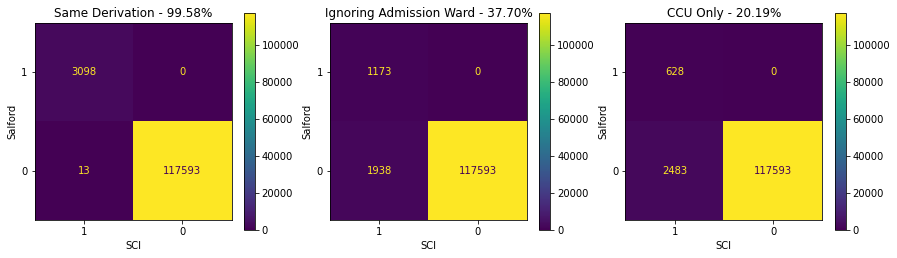

In [46]:
print(f'Common entries: {sci_sal_intersect.shape[0]}/{scii.shape[0]} = {sci_sal_intersect.shape[0]/scii.shape[0]*100:.2f}% overlap.')
print(f'Overlap is {sci_sal_intersect.shape[0]}/{sal.shape[0]} = {sci_sal_intersect.shape[0]/sal.shape[0]*100:.2f}% of Salford data.')

def compare_labels(sal, scii):
    salford_labels = {
        'Same Derivation': sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=False, return_series=True),
        'Ignoring Admission Ward': sal.derive_critical_event(wards=["CCU", "HH1M"], return_series=True),
        'CCU Only': sal.derive_critical_event(wards=["CCU"], ignore_admit_ward=True, return_series=True)
    }

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for i, (title, y_sal) in enumerate(salford_labels.items()):
        y_scii, y_sal = scii.CriticalEvent.loc[sci_sal_intersect], y_sal.loc[sci_sal_intersect]
        title = f'{title} - {(y_scii & y_sal).sum()/y_scii.sum()*100:.2f}%'
        plot_confusion_matrix(y_scii, y_sal, ax=ax[i], plot_title=title, normalize=None, xlabel='SCI', ylabel='Salford')

compare_labels(sal, scii)


### Predictive Modelling

In [4]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, fbeta_score, make_scorer

calibration_parameters = dict(
    ensemble=True,
    cv=3,
    method='isotonic',
    n_jobs=3
)

cross_validation_metrics = dict(
    Precision='precision',
    Recall='recall',
    AUC='roc_auc',
    AP='average_precision',
    F2=make_scorer(fbeta_score, beta=2)
)

In [122]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

In [133]:
sal_X = SalfordData(
    sal.loc[sci_sal_intersect, scores_with_notes_labs_and_hospital]
).convert_str_to_categorical(inplace=False)
sal_y = sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=False, return_series=True).loc[sci_sal_intersect]

lr_transformer = make_column_transformer(
    (make_pipeline(StandardScaler(), SimpleImputer(strategy='median')), make_column_selector(dtype_include=np.number)),
    (make_pipeline(OneHotEncoder(), SimpleImputer(strategy='constant', fill_value=0)), make_column_selector(dtype_include='category')),
    (make_pipeline(OneHotEncoder(drop='if_binary'), SimpleImputer(strategy='most_frequent')), make_column_selector(dtype_include='bool')),
    remainder=SimpleImputer(strategy='constant', fill_value=0)
)

In [138]:
from sklearn.linear_model import LogisticRegression

lr_parameters = dict(
    LR=dict(
        max_iter=500,
        solver="lbfgs",
        random_state=42,
        penalty='none'
    ),
    L1=dict(
        max_iter=500,
        solver="saga",
        random_state=42,
        penalty='l1'
    ),
    L2=dict(
        max_iter=500,
        solver="lbfgs",
        random_state=42,
        penalty='l2'
    ),
    EN=dict(
        max_iter=500,
        solver="saga",
        random_state=42,
        penalty='elasticnet',
        l1_ratio=0.5
    ),
)

pd.concat(
    pd.DataFrame.from_dict(cross_validate(CalibratedClassifierCV(
        LogisticRegression(**parameters), **calibration_parameters
    ), lr_transformer.fit_transform(sal_X), sal_y, cv=5, n_jobs=1, scoring=cross_validation_metrics)).assign(model=modelname)
    for modelname, parameters in lr_parameters.items()
).groupby('model').mean()

,fit_time,score_time,test_Precision,test_Recall,test_AUC,test_AP,test_F2
model,,,,,,,
EN,39.282025,0.031140,0.799613,0.209477,0.891112,0.415732,0.245593
L1,32.388994,0.037401,0.798415,0.210122,0.891040,0.415827,0.246298
L2,3.144793,0.040520,0.790258,0.211091,0.891842,0.415903,0.247199
LR,5.125546,0.049866,0.795596,0.212060,0.889519,0.415836,0.248378


### Dataset Variations

In [68]:
import itertools
from lightgbm import LGBMClassifier
from tqdm import tqdm

RESULTS = []
def old_study_replication(sal, sci_sal_intersect):
    scores_with_notes_labs_and_hospital = ['NEWS_RespiratoryRate_Admission', 'NEWS_O2Sat_Admission', 'NEWS_Temperature_Admission', 'NEWS_BP_Admission', 'NEWS_HeartRate_Admission', 'NEWS_AVCPU_Admission', 'NEWS_BreathingDevice_Admission', 'Female', 'Age', 'Blood_Haemoglobin_Admission', 'Blood_Urea_Admission', 'Blood_Sodium_Admission', 'Blood_Potassium_Admission', 'Blood_Creatinine_Admission', 'AE_PresentingComplaint', 'AE_MainDiagnosis', 'SentToSDEC', 'Readmission', 'AdmitMethod', 'AdmissionSpecialty']
    new_features = ['Blood_DDimer_Admission', 'Blood_CRP_Admission', 'Blood_Albumin_Admission', 'Blood_WhiteCount_Admission', 'Waterlow_Score', 'CFS_Score', 'CharlsonIndex']
    
    X = SalfordData(sal[scores_with_notes_labs_and_hospital + new_features]).convert_str_to_categorical(inplace=False)
    outcomes = {
        "4 Strict Labelling": sal.derive_critical_event(wards=["CCU"], ignore_admit_ward=True, return_series=True),
        "3 H1 but no direct admissions": sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=True, return_series=True),
        "2 Direct admissions but no H1": sal.derive_critical_event(wards=["CCU"], ignore_admit_ward=False, return_series=True),
        "1 SCI Labelling": sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=False, return_series=True)
    }
    feature_sets = {
        "1 SCI Features": scores_with_notes_labs_and_hospital,
        "2 SCI Features (No Adm. Specialty)": scores_with_notes_labs_and_hospital[:-1],
        "3 New Features": scores_with_notes_labs_and_hospital + new_features,
        "4 New Features (No Adm. Speciality)": scores_with_notes_labs_and_hospital[:-1] + new_features
    }
    record_sets = {
        "1 SCI Records": sci_sal_intersect,
        "2 All Records": X.index
    }

    lightgbm_parameters = dict(
        objective='binary',
        random_state=42,
        metrics=['l2', 'auc'],
        boosting_type='gbdt',
        n_jobs=1,
        is_unbalance=True
    )

    for i, ((y_name, y), (x_name, x), (xi_name, xi)) in tqdm(enumerate(itertools.product(outcomes.items(), feature_sets.items(), record_sets.items()))):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            RESULTS.append(
                pd.DataFrame.from_dict(cross_validate(CalibratedClassifierCV(
                    LGBMClassifier(**lightgbm_parameters), **calibration_parameters
                ), X.loc[xi, x], y.loc[xi], cv=5, n_jobs=1, scoring=cross_validation_metrics)).assign(
                    Iter=i,
                    Features=x_name,
                    Records=xi_name,
                    Outcomes=y_name
                )
            )

    return RESULTS

replication_results = pd.concat(old_study_replication(sal, sci_sal_intersect)).drop('Iter', axis=1).groupby(['Records', 'Features', 'Outcomes']).mean()

32it [20:14, 37.95s/it]


In [71]:
replication_results

fit_time  \
Records       Features                            Outcomes                                  
1 SCI Records 1 SCI Features                      1 SCI Labelling                2.437373   
                                                  2 Direct admissions but no H1  2.124346   
                                                  3 H1 but no direct admissions  2.372162   
                                                  4 Strict Labelling             2.812358   
              2 SCI Features (No Adm. Specialty)  1 SCI Labelling                2.269960   
                                                  2 Direct admissions but no H1  2.100080   
                                                  3 H1 but no direct admissions  2.294656   
                                                  4 Strict Labelling             2.114741   
              3 New Features                      1 SCI Labelling                2.867332   
                                                  2 Direct admissions but no H1  2.525194   
                                                  3 H1 but no direct admissions  2.833980   
                                                  4 Strict Labelling             2.536618   
              4 New Features (No Adm. Speciality) 1 SCI Labelling                2.763342   
                                                  2 Direct admissions but no H1  2.442873   
                                                  3 H1 but no direct admissions  2.816825   
                                                  4 Strict Labelling             2.495093   
2 All Records 1 SCI Features                      1 SCI Labelling                8.159246   
                                                  2 Direct admissions but no H1  7.896211   
                                                  3 H1 but no direct admissions  7.636497   
                                                  4 Strict Labelling             7.617007   
              2 SCI Features (No Adm. Specialty)  1 SCI Labelling                7.866374   
                                                  2 Direct admissions but no H1  7.588500   
                                                  3 H1 but no direct admissions  7.104700   
                                                  4 Strict Labelling             7.275162   
              3 New Features                      1 SCI Labelling                9.591510   
                                                  2 Direct admissions but no H1  9.127943   
                                                  3 H1 but no direct admissions  8.883348   
                                                  4 Strict Labelling             9.072117   
              4 New Features (No Adm. Speciality) 1 SCI Labelling                9.194534   
                                                  2 Direct admissions but no H1  9.017458   
                                                  3 H1 but no direct admissions  8.486390   
                                                  4 Strict Labelling             8.535037   

                                                                                 score_time  \
Records       Features                            Outcomes                                    
1 SCI Records 1 SCI Features                      1 SCI Labelling                  0.970057   
                                                  2 Direct admissions but no H1    0.777180   
                                                  3 H1 but no direct admissions    0.958839   
                                                  4 Strict Labelling               0.835410   
              2 SCI Features (No Adm. Specialty)  1 SCI Labelling                  0.924748   
                                                  2 Direct admissions but no H1    0.740436   
                                                  3 H1 but no direct admissions    0.924264   
                                                  4 Strict Labe